## Preparations:

In [1]:
!pip install -Uqq fastbook
!pip install -Uqq kaggle
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXX"
os.environ['KAGGLE_KEY'] = "XXXX"

### Using Kaggle's dataset and API:

In [3]:
from kaggle import api
path = Path('Art')
Path.BASE_PATH = path
path

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [3]:
path = Path('Art')
Path.BASE_PATH = path
path

Path('.')

In [6]:
if not path.exists():
  path.mkdir(parents=true)
  api.dataset_download_files('ikarus777/best-artworks-of-all-time', path=path, unzip=true)
path.ls()

(#2) [Path('images'),Path('artists.csv')]

Albrecht_Du╠êrer and Albrecht_DuΓòá├¬rer is the same painter but in 2 different folders, so let's get rid of it together with resized folder

In [ ]:
import shutil

shutil.rmtree(path/'resized/')

In [4]:
path.ls()

(#2) [Path('images'),Path('artists.csv')]

In [ ]:
shutil.rmtree(path/'images/images/Albrecht_DuΓòá├¬rer')

In [5]:
Path(path/'images/images').ls()

(#50) [Path('images/images/Peter_Paul_Rubens'),Path('images/images/Titian'),Path('images/images/Sandro_Botticelli'),Path('images/images/Jan_van_Eyck'),Path('images/images/Jackson_Pollock'),Path('images/images/El_Greco'),Path('images/images/Raphael'),Path('images/images/Rene_Magritte'),Path('images/images/Pablo_Picasso'),Path('images/images/Joan_Miro')...]

### Creating datablock:

In [8]:
art = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.7, mult=1.5),
                               Normalize.from_stats(*imagenet_stats)])

In [32]:
import torch
torch.cuda.empty_cache()
!rm -rf $HOME/.fastai

## Training with different resnets, and results:

#### 1. Resnet34:

In [28]:
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()

(0.00831763744354248, 0.010964781977236271)

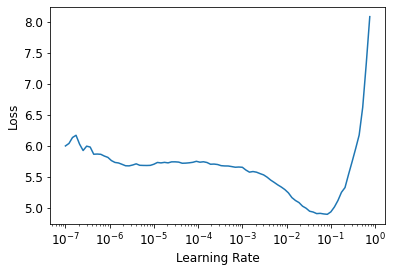

In [29]:
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [30]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.855960,2.062453,0.500888,01:59


epoch,train_loss,valid_loss,accuracy,time
0,1.799152,1.489730,0.617525,02:42
1,1.778039,1.746366,0.566015,02:42
2,1.781182,2.169915,0.523387,02:42
3,1.525440,1.453802,0.613973,02:42
4,1.277708,1.219803,0.681468,02:42
5,1.038528,1.041645,0.717584,02:42
6,0.743037,0.838887,0.769686,02:42
7,0.546192,0.744521,0.804618,02:42
8,0.395112,0.673803,0.815867,02:42
9,0.347249,0.665655,0.817644,02:42


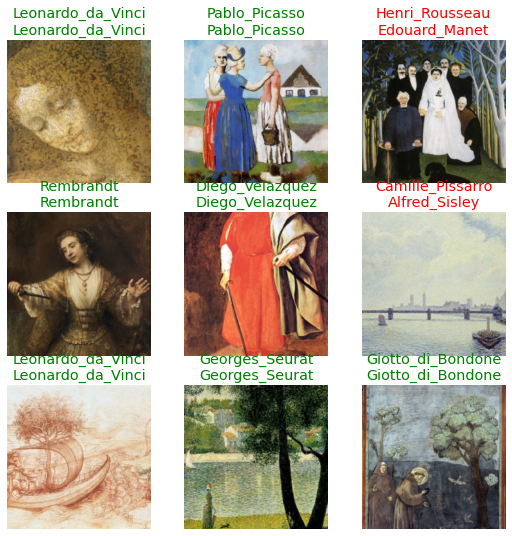

In [31]:
learn.show_results()

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)

[('Claude_Monet', 'Alfred_Sisley', 6),
 ('Edgar_Degas', 'Pablo_Picasso', 6),
 ('Titian', 'Raphael', 6),
 ('Camille_Pissarro', 'Alfred_Sisley', 5)]

#### 2. Resnet18:

In [33]:
learn18 = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16()

(0.005754399299621582, 0.004365158267319202)

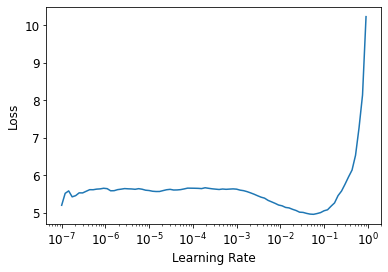

In [34]:
lr_min,lr_steep = learn18.lr_find()
lr_min,lr_steep

In [35]:
learn18.fine_tune(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.790204,1.937496,0.502664,01:22


epoch,train_loss,valid_loss,accuracy,time
0,1.818721,1.360202,0.626998,01:45
1,1.559603,1.244794,0.660746,01:45
2,1.364224,1.292239,0.663706,01:45
3,1.195411,1.170833,0.690941,01:45
4,0.975188,0.998451,0.733570,01:46
5,0.706172,0.998018,0.738307,01:45
6,0.547230,0.888272,0.758437,01:46
7,0.382569,0.811658,0.783896,01:47
8,0.282517,0.744800,0.801658,01:45
9,0.257065,0.738561,0.800474,01:45


In [37]:
interp = ClassificationInterpretation.from_learner(learn18)
interp.most_confused(min_val=5)

[('Titian', 'Raphael', 6), ('Edgar_Degas', 'Vincent_van_Gogh', 5)]

In [ ]:
import torch
torch.cuda.empty_cache()
!rm -rf $HOME/.fastai

#### 3. Resnet50:

In [11]:
learn50 = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


(0.004786301031708717, 0.002511886414140463)

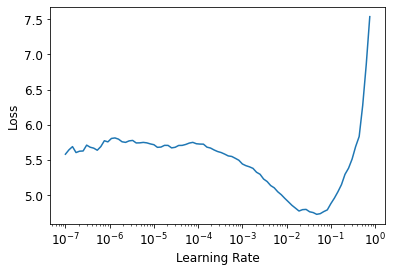

In [12]:
lr_min,lr_steep = learn50.lr_find()
lr_min,lr_steep

In [12]:
learn50.fine_tune(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.508050,1.699414,0.576673,02:51


epoch,train_loss,valid_loss,accuracy,time
0,1.599331,1.233322,0.676140,03:51
1,1.281075,1.103943,0.701007,03:51
2,1.190501,1.074131,0.719361,03:51
3,0.948293,0.900467,0.754885,03:50
4,0.719544,0.864949,0.777383,03:50
5,0.518263,0.812442,0.795145,03:50
6,0.368113,0.716102,0.809947,03:51
7,0.227541,0.682194,0.826525,03:50
8,0.165004,0.676087,0.827117,03:51
9,0.148091,0.657356,0.836590,03:51


In [13]:
learn50.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.712464,1.720021,0.560687,02:50
1,1.895507,1.479753,0.621078,02:50
2,1.570662,1.259674,0.661338,02:50
3,1.366501,1.141568,0.686797,02:50
4,1.187258,1.043526,0.709295,02:49
5,0.977887,0.937236,0.738307,02:49
6,0.784431,0.857273,0.764358,02:49
7,0.645502,0.799041,0.783304,02:49
8,0.581769,0.799931,0.785080,02:50
9,0.528989,0.790480,0.788040,02:52


In [14]:
interp = ClassificationInterpretation.from_learner(learn50)
interp.most_confused(min_val=4)

[('Camille_Pissarro', 'Alfred_Sisley', 5),
 ('Claude_Monet', 'Alfred_Sisley', 5)]

#### 4. WITH MORE AUGMENTATIONS Resnet18:

In [30]:
# Version 2
tsfm = aug_transforms(do_flip=True, # Random 50% flip added
                      flip_vert=True, # Vertical flips are allowed
                      
                      p_affine=0.75, # We apply a random rotation with: a  
                      max_rotate=10.0, # 1. degrees of random rotations,
                      min_zoom=1.0, # 2. random zoom between min_zoom and 
                      max_zoom=1.1, # max_zoom
                      max_warp=0.2, # 3. and a perspective warping of max_warp
                      
                      p_lighting=0.75, # We apply a change in brightness and contrast of max_lighting.
                      max_lighting=0.2,
                      
                      mult=1.5, # max_rotate,max_lighting,max_warp are multiplied by mult 
                      # so you can more easily increase or decrease augmentation with a single parameter.
                      
                      xtra_tfms=None,
                      
                      size=None, # will be used for the interpolation
                      mode='bilinear', # will be used for the interpolation
                      pad_mode='reflection', # will be used for the interpolation
                      
                      align_corners=True,
                      batch=False, 
                      min_scale=1.0
                     )

art = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*tsfm,
                               Normalize.from_stats(*imagenet_stats)])

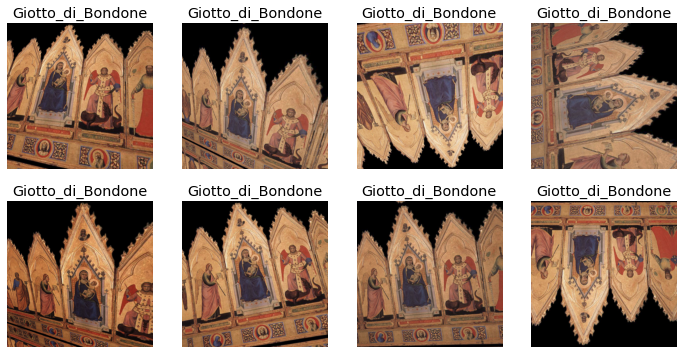

In [31]:
dls = art.dataloaders(path/'images/images', bs=32)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
learn_aug_18 = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16()

(0.004786301031708717, 0.004365158267319202)

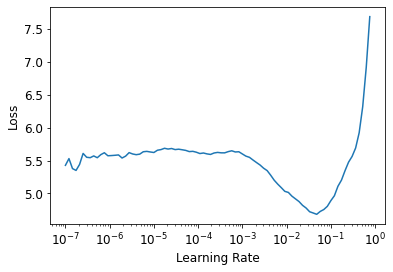

In [37]:
lr_min,lr_steep = learn_aug_18.lr_find()
lr_min,lr_steep

In [38]:
learn_aug_18.fine_tune(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.427557,1.691462,0.551214,04:21


epoch,train_loss,valid_loss,accuracy,time
0,1.597437,1.181564,0.670811,05:51
1,1.336807,1.124060,0.695678,05:51
2,1.313618,1.138542,0.709888,05:50
3,1.135358,1.042507,0.711664,05:52
4,0.972089,0.958607,0.735346,05:52
5,0.798471,0.788900,0.794553,05:50
6,0.572583,0.771189,0.794553,05:51
7,0.439706,0.668485,0.825340,05:51
8,0.340288,0.675440,0.827709,05:50
9,0.295647,0.644463,0.832445,05:51


In [41]:
interp = ClassificationInterpretation.from_learner(learn_aug_18)
interp.most_confused(min_val=4)

[('Titian', 'Raphael', 6),
 ('Alfred_Sisley', 'Camille_Pissarro', 5),
 ('Camille_Pissarro', 'Paul_Gauguin', 5),
 ('Claude_Monet', 'Alfred_Sisley', 5),
 ('Camille_Pissarro', 'Kazimir_Malevich', 4),
 ('Edgar_Degas', 'Pablo_Picasso', 4),
 ('Francisco_Goya', 'Peter_Paul_Rubens', 4),
 ('Henri_de_Toulouse-Lautrec', 'Vincent_van_Gogh', 4),
 ('Marc_Chagall', 'Pablo_Picasso', 4)]

#### 5. WITH MORE AUGMENTATIONS BLACK AND WHITE Resnet18:

In [15]:
# Version 3 with black and white
tsfm = aug_transforms(mult=1.5, do_flip=True, flip_vert=True, max_rotate=10.0, min_zoom=1.0, 
               max_zoom=1.1, max_warp=0.2, p_affine=0.75, 
               xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, 
               batch=False, min_scale=1.0)
art = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[Saturation(max_lighting=0.2, p=1., draw=0., batch=False), 
                               Normalize.from_stats(*imagenet_stats)])

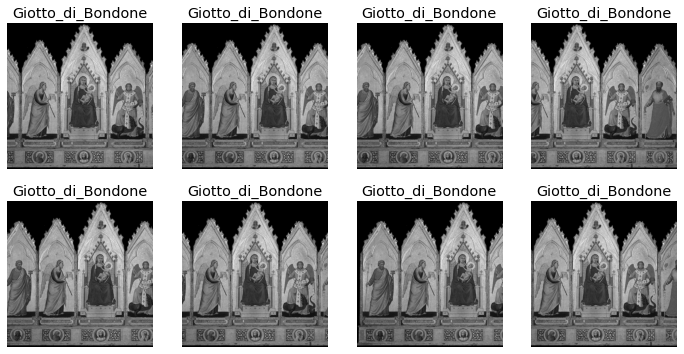

In [16]:
dls = art.dataloaders(path/'images/images', bs=32)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
learn_augbw_18 = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


(0.006918309628963471, 0.010964781977236271)

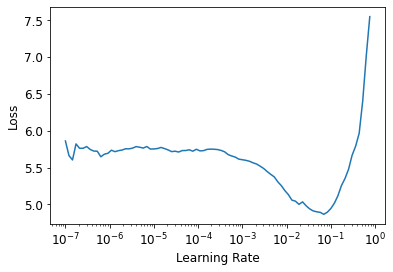

In [12]:
lr_min,lr_steep = learn_augbw_18.lr_find()
lr_min,lr_steep

In [18]:
learn_augbw_18.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.664956,10.778521,0.069272,04:15


epoch,train_loss,valid_loss,accuracy,time
0,1.596561,14.146012,0.090586,05:45
1,1.564424,11.488319,0.075192,05:45
2,1.628872,10.163877,0.075784,05:45
3,1.317326,6.913278,0.107164,05:46
4,1.040460,7.042253,0.126702,05:46
5,0.735114,9.768427,0.112493,05:46
6,0.360444,7.120549,0.134399,05:46
7,0.221760,9.204660,0.134399,05:46
8,0.083123,8.906944,0.137359,05:46
9,0.076889,8.793800,0.140912,05:47


In [19]:
interp = ClassificationInterpretation.from_learner(learn_augbw_18)
interp.most_confused(min_val=4)

[('Vincent_van_Gogh', 'Rene_Magritte', 98),
 ('Edgar_Degas', 'Rene_Magritte', 94),
 ('Titian', 'Rene_Magritte', 47),
 ('Pierre-Auguste_Renoir', 'Rene_Magritte', 38),
 ('Rembrandt', 'Rene_Magritte', 38),
 ('Vincent_van_Gogh', 'Frida_Kahlo', 33),
 ('Edgar_Degas', 'Pablo_Picasso', 29),
 ('Edgar_Degas', 'Frida_Kahlo', 28),
 ('Paul_Gauguin', 'Rene_Magritte', 26),
 ('Francisco_Goya', 'Rene_Magritte', 24),
 ('Sandro_Botticelli', 'Rene_Magritte', 24),
 ('Hieronymus_Bosch', 'Rene_Magritte', 23),
 ('Pablo_Picasso', 'Rene_Magritte', 23),
 ('Salvador_Dali', 'Rene_Magritte', 21),
 ('Henri_Matisse', 'Rene_Magritte', 20),
 ('Paul_Gauguin', 'Frida_Kahlo', 20),
 ('Frida_Kahlo', 'Rene_Magritte', 17),
 ('Alfred_Sisley', 'Rene_Magritte', 15),
 ('Andrei_Rublev', 'Rene_Magritte', 15),
 ('Diego_Velazquez', 'Rene_Magritte', 15),
 ('Leonardo_da_Vinci', 'Rene_Magritte', 15),
 ('Peter_Paul_Rubens', 'Rene_Magritte', 15),
 ('William_Turner', 'Rene_Magritte', 15),
 ('Gustav_Klimt', 'Rene_Magritte', 14),
 ('Henri_Ro

#### 6. WITH MORE AUGMENTATIONS Resnet50:


In [6]:
# Version 2
tsfm = aug_transforms(do_flip=True, # Random 50% flip added
                      flip_vert=True, # Vertical flips are allowed
                      
                      p_affine=0.75, # We apply a random rotation with: a  
                      max_rotate=10.0, # 1. degrees of random rotations,
                      min_zoom=1.0, # 2. random zoom between min_zoom and 
                      max_zoom=1.1, # max_zoom
                      max_warp=0.2, # 3. and a perspective warping of max_warp
                      
                      p_lighting=0.75, # We apply a change in brightness and contrast of max_lighting.
                      max_lighting=0.2,
                      
                      mult=1.5, # max_rotate,max_lighting,max_warp are multiplied by mult 
                      # so you can more easily increase or decrease augmentation with a single parameter.
                      
                      xtra_tfms=None,
                      
                      size=None, # will be used for the interpolation
                      mode='bilinear', # will be used for the interpolation
                      pad_mode='reflection', # will be used for the interpolation
                      
                      align_corners=True,
                      batch=False, 
                      min_scale=1.0
                     )

art = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*tsfm,
                               Normalize.from_stats(*imagenet_stats)])

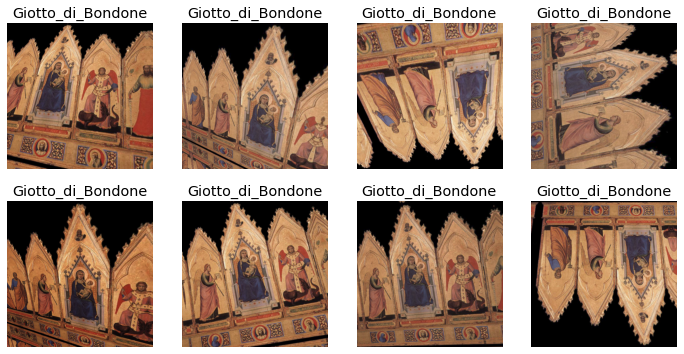

In [7]:
dls = art.dataloaders(path/'images/images', bs=32)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [8]:
learn_aug_50 = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


(0.004786301031708717, 0.00363078061491251)

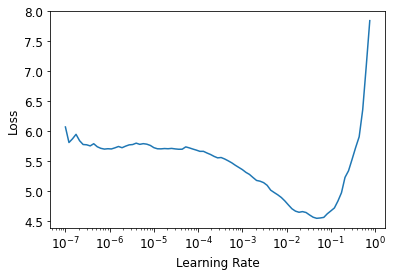

In [9]:
lr_min,lr_steep = learn_aug_50.lr_find()
lr_min,lr_steep

In [ ]:
learn_aug_50.fine_tune(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.194270,1.476232,0.616341,10:29


epoch,train_loss,valid_loss,accuracy,time
0,1.287976,0.945005,0.742451,14:43
1,1.198386,0.978587,0.747188,14:42
2,1.140886,1.068924,0.716400,14:42
3,1.015171,0.966662,0.753108,14:42
4,0.804518,0.885363,0.760805,14:41
5,0.633355,0.699295,0.808170,14:41


In [ ]:
interp = ClassificationInterpretation.from_learner(learn_aug_50)
interp.most_confused(min_val=4)

...

## Making an app

In [15]:
learn50.export()

In [16]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [17]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
learn_inf.dls.vocab

['Albrecht_Du╠êrer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']

In [19]:
from fastai.vision.widgets import *
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [20]:
img = PILImage.create(btn_upload.data[-1])

In [21]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [22]:
pred,pred_idx,probs = learn_inf.predict(img)

In [23]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Camille_Pissarro; Probability: 0.7854')

In [24]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [25]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [26]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [28]:
#hide_output
VBox([widgets.Label('Select your painting!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [30]:
#hide
!pip install -Uqq voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.7 OK


/bin/bash: heroku: command not found
